In [2]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2024-12-06 12:30:45.159054: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733455845.170937 1374857 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733455845.174463 1374857 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-06 12:30:45.188519: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found GPU at: /device:GPU:0


I0000 00:00:1733455847.452546 1374857 gpu_device.cc:2022] Created device /device:GPU:0 with 17815 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:81:00.0, compute capability: 8.6


In [3]:
import os
import cv2
import pandas as pd

In [4]:
from PIL import Image
def create_df(data_path):
    """
         이미지데이터의 경로와 label데이터로 데이터프레임 만들기 
    """
    df = pd.DataFrame({})
    data_dir_list = os.listdir(data_path)
    print(data_dir_list)
    for i in range(len(data_dir_list)):
      file_list = os.listdir(data_path + "/" + data_dir_list[i])
      img_path_list = []
      for j in range(len(file_list)):
        img_path = data_path + "/" + data_dir_list[i] + "/" +file_list[j]
        try:
          image = Image.open(img_path)
          image.verify()
          img_path_list.append(img_path)
        except:
          print(img_path)
          pass
      df = pd.concat([df,pd.DataFrame({'File_path':img_path_list,'Label':data_dir_list[i]})])
      print(data_dir_list[i],len(file_list))

    # index 재설정
    df = df.sample(frac=1,random_state=0).reset_index(drop = True)
    return df

In [5]:
df = create_df('dataset/train')

['hh', 'cse', 'wb', 'wjj', 'rg']
hh 752
cse 1159
wb 1028
wjj 1053
rg 1036


In [6]:
display(df)

,File_path,Label
0,dataset/train/wb/train_wb_video170.png,wb
1,dataset/train/rg/train_rg_199.png,rg
2,dataset/train/rg/train_rg_17.png,rg
3,dataset/train/cse/train_cse_video317.png,cse
4,dataset/train/wb/train_wb_306.png,wb
...,...,...
5023,dataset/train/rg/train_rg_164.png,rg
5024,dataset/train/wjj/train_wjj_159.png,wjj
5025,dataset/train/cse/train_cse_330.png,cse
5026,dataset/train/wb/train_wb_video268.png,wb


In [7]:
import numpy as np
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size=0.1, random_state=0, stratify=df.Label)
print(train_df.shape, val_df.shape)

(4525, 2) (503, 2)


In [8]:
test_df = create_df('dataset/test')

['hh', 'cse', 'wb', 'wjj', 'rg']
hh 88
cse 126
wb 113
wjj 124
rg 113


In [ ]:
import numpy as np
import tensorflow as tf
def create_gen():
    # 생성기 및 데이터 증강으로 이미지 로드
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

    val_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='File_path',
        y_col='Label',
        target_size=(150, 150),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=64,
        shuffle=True
    )

    val_images = val_generator.flow_from_dataframe(
        dataframe=val_df,
        x_col='File_path',
        y_col='Label',
        target_size=(150, 150),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=64,
        shuffle=True
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='File_path',
        y_col='Label',
        target_size=(150, 150),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=64,
        shuffle=False
    )
    
    return train_generator, val_generator, test_generator, train_images, val_images, test_images

In [11]:
train_generator, val_generator, test_generator, train_images, val_images, test_images = create_gen()

Found 4525 validated image filenames belonging to 5 classes.
Found 503 validated image filenames belonging to 5 classes.
Found 564 validated image filenames belonging to 5 classes.


In [12]:
len(train_images) # batch_size가 64 이므로,

71

In [13]:
with tf.device('/device:GPU:0'):
    
    cnn = tf.keras.models.Sequential()
    
    # 1CMD Convolution Layer, MaxPooling Layer
    cnn.add(tf.keras.layers.Conv2D(64, kernel_size=3, padding="same", activation="relu", input_shape=(150, 150, 3)))
    cnn.add(tf.keras.layers.MaxPool2D(padding="same"))
    
    cnn.add(tf.keras.layers.Conv2D(64, kernel_size=3, padding="same", activation="relu", input_shape=(150, 150, 3)))
    cnn.add(tf.keras.layers.MaxPool2D(padding="same"))
    
    cnn.add(tf.keras.layers.Conv2D(128, kernel_size=3, padding="same", activation="relu", input_shape=(150, 150, 3)))
    cnn.add(tf.keras.layers.MaxPool2D(padding="same"))
    
    cnn.add(tf.keras.layers.Conv2D(128, kernel_size=3, padding="same", activation="relu", input_shape=(150, 150, 3)))
    cnn.add(tf.keras.layers.MaxPool2D(padding="same"))
    
    # classification layer
    cnn.add(tf.keras.layers.Flatten())
    cnn.add(tf.keras.layers.Dropout(0.5))
    cnn.add(tf.keras.layers.Dense(512, activation="relu"))
    
    cnn.add(tf.keras.layers.Dense(units=5, activation='softmax'))
    
    cnn.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
    
    cnn.summary()

I0000 00:00:1733456399.798963 1374857 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 17815 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:81:00.0, compute capability: 8.6
/home/team105/miniconda3/envs/tensorflow/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 38, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 38, 38, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 19, 19, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 19, 19, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     6,554,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,816,837 (26.00 MB)

 Trainable params: 6,816,837 (26.00 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
history = cnn.fit(x=train_images, validation_data=val_images, validation_steps=5, epochs=10, verbose=1)

/home/team105/miniconda3/envs/tensorflow/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1733456571.417523 1377062 service.cc:148] XLA service 0x7f8274003680 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733456571.417583 1377062 service.cc:156]   StreamExecutor device (0): NVIDIA RTX A5000, Compute Capability 8.6
2024-12-06 12:42:51.450783: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1733456571.595028 1377062 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/71 ━━━━━━━━━━━━━━━━━━━━ 7:27 6s/step - accuracy: 0.1875 - loss: 1.6332

I0000 00:00:1733456575.387164 1377062 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


71/71 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - accuracy: 0.3190 - loss: 1.5170 - val_accuracy: 0.6219 - val_loss: 0.9835
Epoch 2/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.6576 - loss: 0.8962 - val_accuracy: 0.8250 - val_loss: 0.5056
Epoch 3/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.7724 - loss: 0.6152 - val_accuracy: 0.8500 - val_loss: 0.4048
Epoch 4/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.8368 - loss: 0.4450 - val_accuracy: 0.8625 - val_loss: 0.4330
Epoch 5/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.8750 - loss: 0.3464 - val_accuracy: 0.8281 - val_loss: 0.4947
Epoch 6/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.9111 - loss: 0.2593 - val_accuracy: 0.8750 - val_loss: 0.3730
Epoch 7/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.9477 - loss: 0.1584 - val_accuracy: 0.8969 - val_loss: 0.3261
Epoch 8/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.9555 - loss: 0.1236 - val_accuracy: 0.9062 - val_loss: 0.3019
Epo

In [15]:
cnn.save('model.h5')

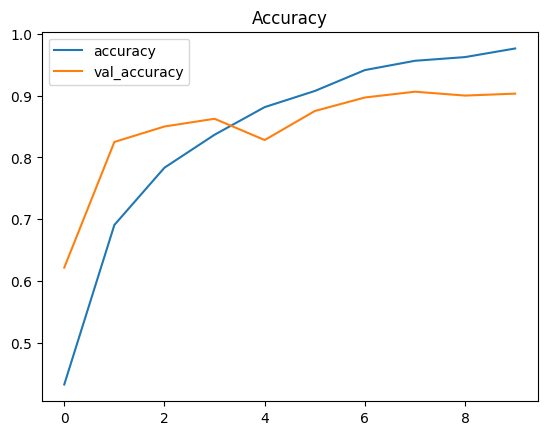

In [16]:
import matplotlib.pyplot as plt

pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
plt.title('Accuracy')
plt.show()

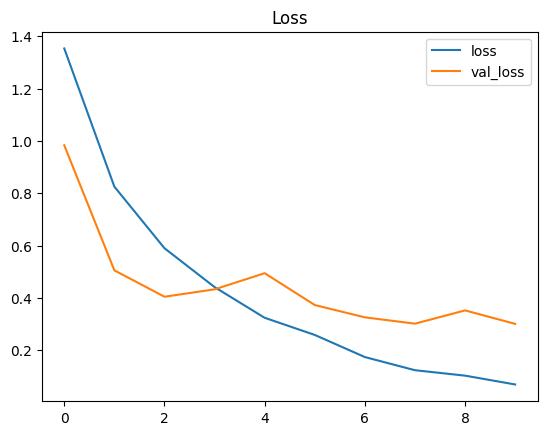

In [17]:
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.title('Loss')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


'예측률 : 100.00%'

'클래스 = wjj'

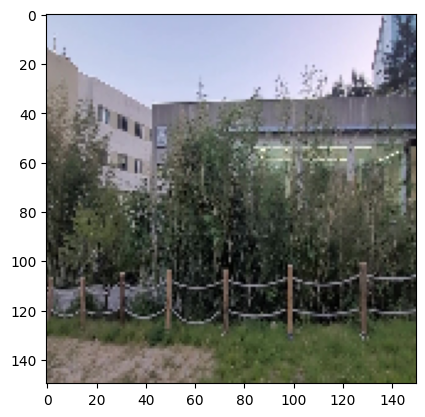

In [18]:
#모델 로드 후 개별 이미지 예측 테스트
import pandas as pd
from keras.preprocessing import image
from keras.models import load_model
import matplotlib.pyplot as plt
def printmd(string):
    display(string)
class_dictionary = test_images.class_indices
model = load_model('./model.h5')
IMAGE_SIZE    = (150, 150)
number_1 = int(input("번호 입력 : ")) # 10, 50, 100
test_image = image.load_img(test_df.iloc[number_1, 0]
                            ,target_size =IMAGE_SIZE )
test_image = image.img_to_array(test_image)
plt.imshow(test_image/255.);

test_image = test_image.reshape((1, test_image.shape[0], test_image.shape[1], test_image.shape[2]))
prediction = model.predict(test_image)

df = pd.DataFrame({'pred':prediction[0]})
df = df.sort_values(by='pred', ascending=False, na_position='first')
printmd(f"예측률 : {(df.iloc[0]['pred'])* 100:.2f}%")

for x in class_dictionary:
  if class_dictionary[x] == (df[df == df.iloc[0]].index[0]):
    printmd(f"클래스 = {x}")
    break

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


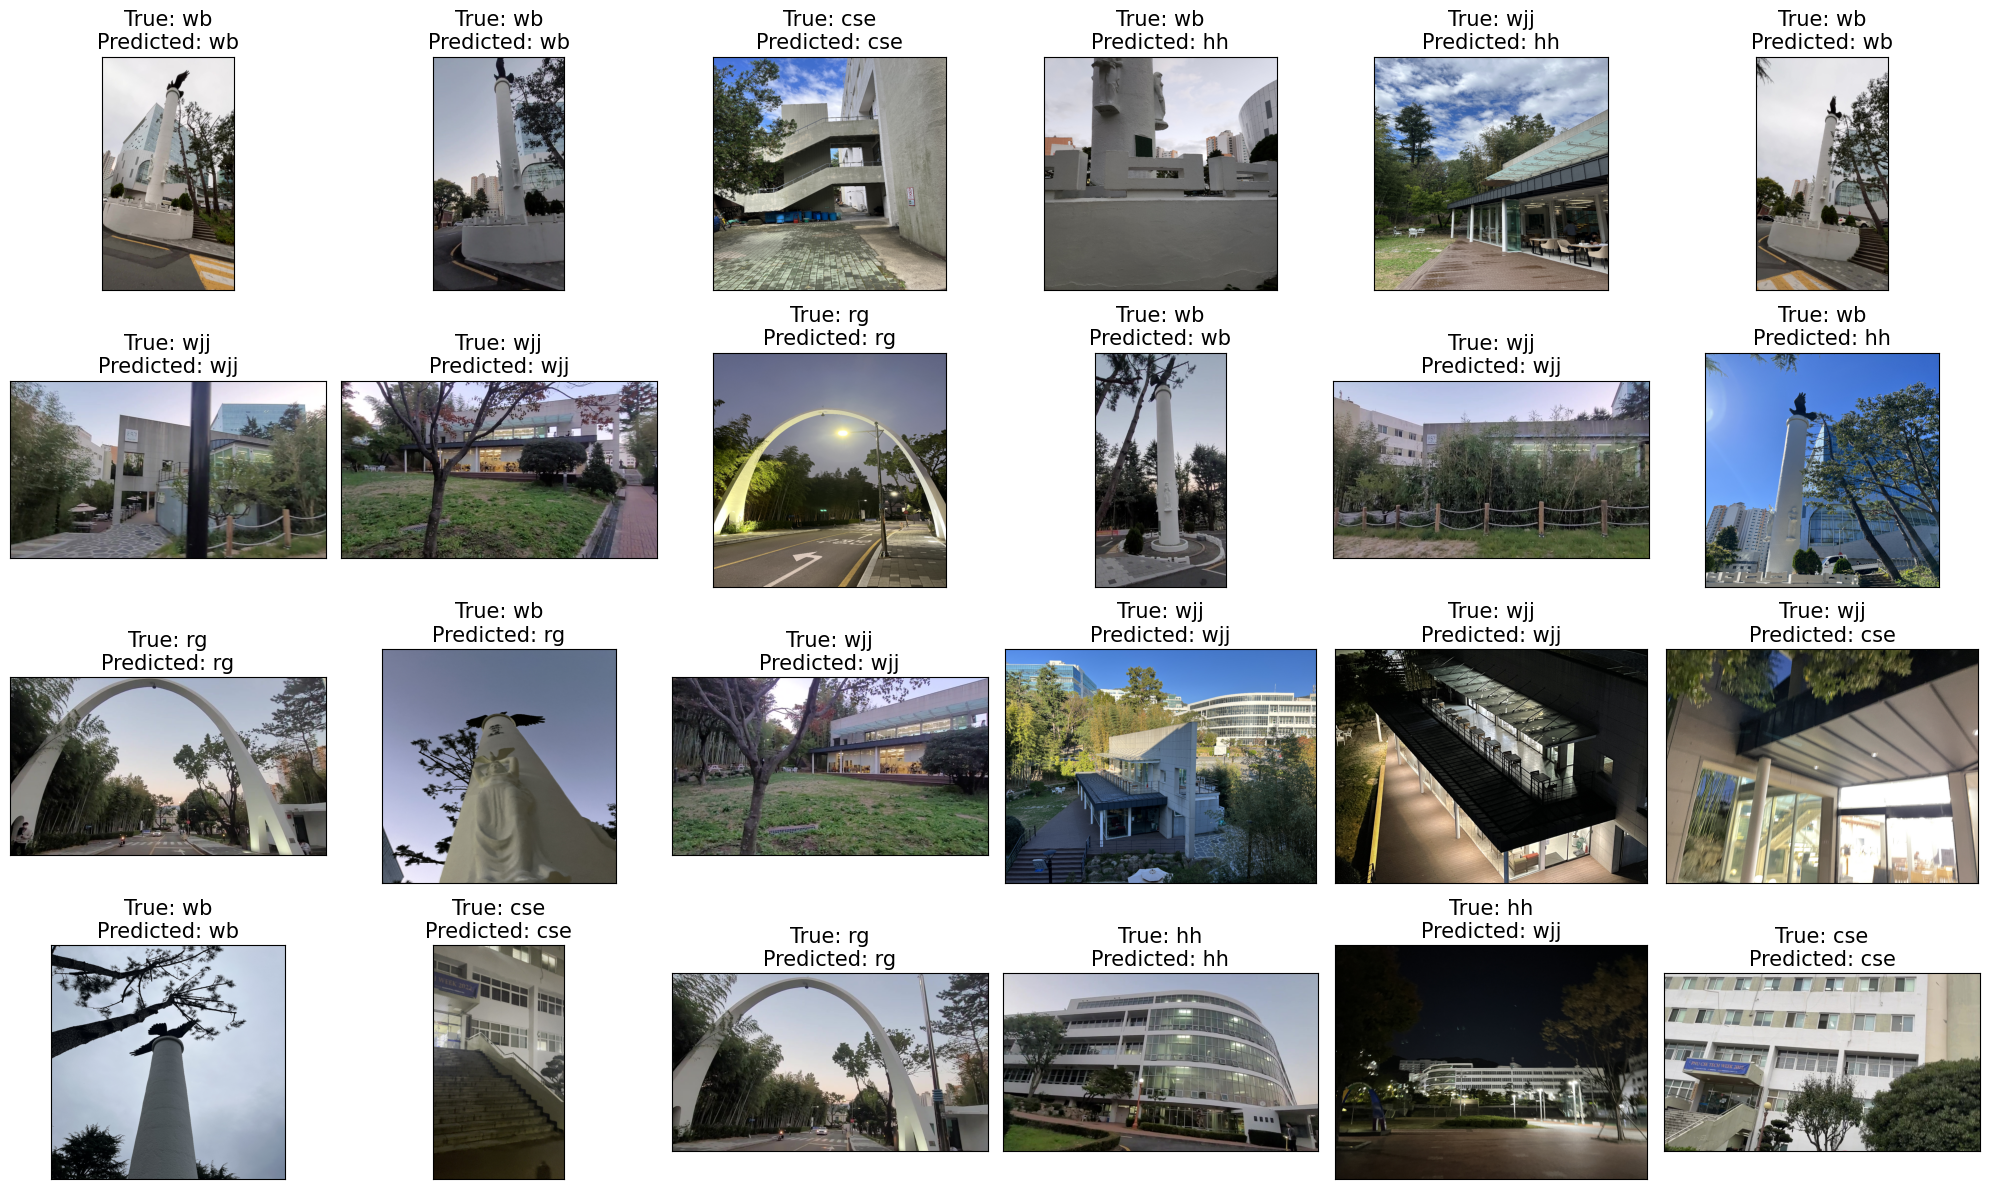

In [19]:
#여러 이미지 테스트
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(20, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.File_path.iloc[i]))
    test_image = image.load_img(test_df.iloc[i, 0]
                            ,target_size =IMAGE_SIZE )
    test_image = image.img_to_array(test_image)
    test_image = test_image.reshape((1, test_image.shape[0], test_image.shape[1], test_image.shape[2]))
    prediction = model.predict(test_image)
    df = pd.DataFrame({'pred':prediction[0]})
    df = df.sort_values(by='pred', ascending=False, na_position='first')
    for x in class_dictionary:
      if class_dictionary[x] == (df[df == df.iloc[0]].index[0]):
        ax.set_title(f"True: {test_df.Label.iloc[i].split('_')[0]}\nPredicted: {x}", fontsize = 15)
plt.tight_layout()
plt.show()

In [21]:
import tensorflow as tf
import numpy as np
from tqdm import tqdm
model = tf.keras.models.load_model('./model.h5')
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)
test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='File_path',
        y_col='Label',
        target_size=(150, 150),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=1,
        shuffle=False)

result = dict()
for cls in test_images.class_indices.keys():
        result[test_images.class_indices[cls]] = [0, 0]
pbar = tqdm(total=test_images.samples, dynamic_ncols=True)
for batch, sample in enumerate(test_images):
        img, label = sample[0], int(np.argmax(sample[1],1))
        output = model.predict(img)
        pred = int(np.argmax(output,1))
        gt = label

        result[gt][1] += 1
        if pred == gt:
                result[gt][0] += 1
        if batch == int(test_images.samples):
                break
        pbar.update(1)

pbar.close()
correct_all = 0
total_all = 0
classes = dict(map(reversed,test_images.class_indices.items()))
for k, v in result.items():
        cls = classes[k]
        correct = result[k][0]
        total = result[k][1]
        acc = 100. * correct / (total + 1e-8)
        print('{:^8s} | {:^8d} | {:^8d} | {:>10.4f}'.format(
                cls, correct, total, acc
        ))

        correct_all += correct
        total_all += total

acc_all = 100. * correct_all / (total_all + 1e-8)
print('{:^8s} | {:^8d} | {:^8d} | {:>10.4f}'.format("ALL", correct_all, total_all, acc_all))

Found 564 validated image filenames belonging to 5 classes.


  0%|          | 0/564 [00:00<?, ?it/s]/tmp/ipykernel_1374857/505339568.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  img, label = sample[0], int(np.argmax(sample[1],1))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


/tmp/ipykernel_1374857/505339568.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred = int(np.argmax(output,1))
  0%|          | 1/564 [00:00<03:07,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  1%|          | 3/564 [00:00<01:29,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  1%|          | 4/564 [00:00<01:18,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  1%|          | 6/564 [00:00<01:05,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  1%|▏         | 8/564 [00:01<01:02,  8.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  2%|▏         | 10/564 [00:01<00:58,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  2%|▏         | 11/564 [00:01<00:58,  9.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  2%|▏         | 13/564 [00:01<00:56,  9.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  3%|▎         | 15/564 [00:01<00:55,  9.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  3%|▎         | 17/564 [00:01<00:55,  9.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  3%|▎         | 18/564 [00:02<00:55,  9.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  4%|▎         | 20/564 [00:02<00:52, 10.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  4%|▍         | 22/564 [00:02<00:52, 10.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  4%|▍         | 24/564 [00:02<00:53, 10.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  5%|▍         | 26/564 [00:02<00:53, 10.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  5%|▍         | 28/564 [00:02<00:52, 10.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  5%|▌         | 30/564 [00:03<00:52, 10.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  6%|▌         | 32/564 [00:03<00:53,  9.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  6%|▌         | 33/564 [00:03<00:54,  9.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  6%|▌         | 34/564 [00:03<00:54,  9.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  6%|▋         | 36/564 [00:03<00:53,  9.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  7%|▋         | 38/564 [00:04<00:52, 10.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  7%|▋         | 39/564 [00:04<00:52,  9.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  7%|▋         | 40/564 [00:04<00:52,  9.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  7%|▋         | 42/564 [00:04<00:50, 10.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  8%|▊         | 44/564 [00:04<00:50, 10.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  8%|▊         | 46/564 [00:04<00:52,  9.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  8%|▊         | 47/564 [00:04<00:52,  9.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  9%|▊         | 49/564 [00:05<00:50, 10.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  9%|▉         | 51/564 [00:05<00:50, 10.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  9%|▉         | 53/564 [00:05<00:50, 10.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 10%|▉         | 55/564 [00:05<00:50, 10.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 10%|█         | 57/564 [00:05<00:50, 10.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 10%|█         | 59/564 [00:06<00:50,  9.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 11%|█         | 61/564 [00:06<00:49, 10.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 11%|█         | 63/564 [00:06<00:49, 10.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 12%|█▏        | 65/564 [00:06<00:49, 10.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 12%|█▏        | 67/564 [00:06<00:49, 10.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 12%|█▏        | 69/564 [00:07<00:49,  9.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 13%|█▎        | 71/564 [00:07<00:48, 10.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 13%|█▎        | 73/564 [00:07<00:47, 10.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 13%|█▎        | 75/564 [00:07<00:47, 10.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 14%|█▎        | 77/564 [00:07<00:46, 10.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 14%|█▍        | 79/564 [00:08<00:46, 10.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 14%|█▍        | 81/564 [00:08<00:47, 10.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 15%|█▍        | 83/564 [00:08<00:46, 10.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 15%|█▌        | 85/564 [00:08<00:47, 10.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 15%|█▌        | 87/564 [00:08<00:46, 10.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 16%|█▌        | 89/564 [00:09<00:46, 10.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 16%|█▌        | 91/564 [00:09<00:46, 10.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 16%|█▋        | 93/564 [00:09<00:47,  9.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 17%|█▋        | 95/564 [00:09<00:46, 10.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 17%|█▋        | 97/564 [00:09<00:47,  9.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 18%|█▊        | 99/564 [00:10<00:46, 10.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 18%|█▊        | 101/564 [00:10<00:46,  9.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 18%|█▊        | 103/564 [00:10<00:45, 10.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 19%|█▊        | 105/564 [00:10<00:46,  9.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 19%|█▉        | 106/564 [00:10<00:46,  9.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 19%|█▉        | 107/564 [00:10<00:46,  9.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 19%|█▉        | 108/564 [00:10<00:46,  9.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 19%|█▉        | 109/564 [00:11<00:46,  9.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 20%|█▉        | 110/564 [00:11<00:46,  9.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 20%|█▉        | 111/564 [00:11<00:46,  9.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 20%|█▉        | 112/564 [00:11<00:46,  9.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 20%|██        | 114/564 [00:11<00:43, 10.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 21%|██        | 116/564 [00:11<00:43, 10.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 21%|██        | 118/564 [00:11<00:43, 10.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 21%|██▏       | 120/564 [00:12<00:44, 10.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 22%|██▏       | 122/564 [00:12<00:44, 10.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 22%|██▏       | 124/564 [00:12<00:43, 10.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 22%|██▏       | 126/564 [00:12<00:43, 10.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 23%|██▎       | 128/564 [00:12<00:44,  9.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 23%|██▎       | 129/564 [00:13<00:44,  9.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 23%|██▎       | 131/564 [00:13<00:43,  9.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 24%|██▎       | 133/564 [00:13<00:42, 10.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 24%|██▍       | 135/564 [00:13<00:42, 10.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 24%|██▍       | 137/564 [00:13<00:41, 10.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 25%|██▍       | 139/564 [00:14<00:40, 10.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 25%|██▌       | 141/564 [00:14<00:40, 10.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 25%|██▌       | 143/564 [00:14<00:40, 10.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 26%|██▌       | 145/564 [00:14<00:40, 10.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 26%|██▌       | 147/564 [00:14<00:40, 10.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 26%|██▋       | 149/564 [00:14<00:39, 10.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 27%|██▋       | 151/564 [00:15<00:40, 10.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 27%|██▋       | 153/564 [00:15<00:40, 10.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 27%|██▋       | 155/564 [00:15<00:39, 10.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 28%|██▊       | 157/564 [00:15<00:39, 10.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 28%|██▊       | 159/564 [00:15<00:39, 10.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 29%|██▊       | 161/564 [00:16<00:39, 10.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 29%|██▉       | 163/564 [00:16<00:39, 10.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 29%|██▉       | 165/564 [00:16<00:40,  9.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 29%|██▉       | 166/564 [00:16<00:41,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 30%|██▉       | 168/564 [00:16<00:40,  9.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 30%|██▉       | 169/564 [00:16<00:40,  9.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 30%|███       | 171/564 [00:17<00:39,  9.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 31%|███       | 173/564 [00:17<00:38, 10.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 31%|███       | 174/564 [00:17<00:38, 10.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 31%|███       | 176/564 [00:17<00:38, 10.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 31%|███▏      | 177/564 [00:17<00:40,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 32%|███▏      | 178/564 [00:17<00:39,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 32%|███▏      | 179/564 [00:18<00:40,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 32%|███▏      | 180/564 [00:18<00:40,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 32%|███▏      | 182/564 [00:18<00:38,  9.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 32%|███▏      | 183/564 [00:18<00:38,  9.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 33%|███▎      | 185/564 [00:18<00:37, 10.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 33%|███▎      | 186/564 [00:18<00:37, 10.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 33%|███▎      | 188/564 [00:18<00:37,  9.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 34%|███▎      | 189/564 [00:19<00:38,  9.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 34%|███▎      | 190/564 [00:19<00:38,  9.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 34%|███▍      | 192/564 [00:19<00:37,  9.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 34%|███▍      | 193/564 [00:19<00:38,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 34%|███▍      | 194/564 [00:19<00:39,  9.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 35%|███▍      | 195/564 [00:19<00:41,  8.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 35%|███▍      | 196/564 [00:19<00:40,  9.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 35%|███▌      | 198/564 [00:19<00:39,  9.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 35%|███▌      | 199/564 [00:20<00:39,  9.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 35%|███▌      | 200/564 [00:20<00:39,  9.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 36%|███▌      | 201/564 [00:20<00:39,  9.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 36%|███▌      | 203/564 [00:20<00:36,  9.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 36%|███▌      | 204/564 [00:20<00:36,  9.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 37%|███▋      | 206/564 [00:20<00:35,  9.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 37%|███▋      | 207/564 [00:20<00:36,  9.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 37%|███▋      | 208/564 [00:21<00:36,  9.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 37%|███▋      | 210/564 [00:21<00:35, 10.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 37%|███▋      | 211/564 [00:21<00:35, 10.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 38%|███▊      | 212/564 [00:21<00:37,  9.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 38%|███▊      | 213/564 [00:21<00:38,  9.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 38%|███▊      | 214/564 [00:21<00:38,  9.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 38%|███▊      | 215/564 [00:21<00:38,  9.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 38%|███▊      | 216/564 [00:21<00:38,  9.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 39%|███▊      | 218/564 [00:22<00:36,  9.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 39%|███▉      | 219/564 [00:22<00:36,  9.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 39%|███▉      | 220/564 [00:22<00:35,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 39%|███▉      | 221/564 [00:22<00:35,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 39%|███▉      | 222/564 [00:22<00:35,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 40%|███▉      | 223/564 [00:22<00:35,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 40%|███▉      | 224/564 [00:22<00:36,  9.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 40%|███▉      | 225/564 [00:22<00:35,  9.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 40%|████      | 226/564 [00:22<00:35,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 40%|████      | 227/564 [00:23<00:35,  9.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 40%|████      | 228/564 [00:23<00:34,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 41%|████      | 230/564 [00:23<00:34,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 41%|████      | 231/564 [00:23<00:34,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 41%|████▏     | 233/564 [00:23<00:34,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 42%|████▏     | 235/564 [00:23<00:33,  9.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 42%|████▏     | 236/564 [00:23<00:33,  9.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 42%|████▏     | 237/564 [00:24<00:33,  9.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 42%|████▏     | 238/564 [00:24<00:33,  9.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 42%|████▏     | 239/564 [00:24<00:33,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 43%|████▎     | 240/564 [00:24<00:33,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 43%|████▎     | 241/564 [00:24<00:33,  9.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 43%|████▎     | 242/564 [00:24<00:34,  9.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 43%|████▎     | 244/564 [00:24<00:33,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 43%|████▎     | 245/564 [00:24<00:33,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 44%|████▎     | 246/564 [00:24<00:33,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 44%|████▍     | 247/564 [00:25<00:33,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 44%|████▍     | 248/564 [00:25<00:34,  9.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 44%|████▍     | 249/564 [00:25<00:33,  9.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 45%|████▍     | 251/564 [00:25<00:32,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 45%|████▍     | 252/564 [00:25<00:32,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 45%|████▍     | 253/564 [00:25<00:32,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 45%|████▌     | 254/564 [00:25<00:32,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 45%|████▌     | 255/564 [00:25<00:31,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 46%|████▌     | 257/564 [00:26<00:30,  9.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 46%|████▌     | 258/564 [00:26<00:31,  9.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 46%|████▌     | 259/564 [00:26<00:32,  9.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 46%|████▌     | 260/564 [00:26<00:32,  9.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 46%|████▋     | 261/564 [00:26<00:32,  9.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 46%|████▋     | 262/564 [00:26<00:31,  9.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 47%|████▋     | 263/564 [00:26<00:31,  9.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 47%|████▋     | 264/564 [00:26<00:31,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 47%|████▋     | 265/564 [00:26<00:31,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 47%|████▋     | 267/564 [00:27<00:31,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 48%|████▊     | 268/564 [00:27<00:31,  9.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 48%|████▊     | 269/564 [00:27<00:31,  9.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 48%|████▊     | 270/564 [00:27<00:30,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 48%|████▊     | 271/564 [00:27<00:30,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 48%|████▊     | 272/564 [00:27<00:31,  9.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 48%|████▊     | 273/564 [00:27<00:31,  9.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 49%|████▊     | 274/564 [00:27<00:30,  9.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 49%|████▉     | 275/564 [00:28<00:30,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 49%|████▉     | 276/564 [00:28<00:31,  9.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 49%|████▉     | 278/564 [00:28<00:30,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 49%|████▉     | 279/564 [00:28<00:29,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 50%|████▉     | 280/564 [00:28<00:29,  9.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 50%|████▉     | 281/564 [00:28<00:29,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 50%|█████     | 282/564 [00:28<00:29,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 50%|█████     | 283/564 [00:28<00:29,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 50%|█████     | 284/564 [00:28<00:29,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 51%|█████     | 285/564 [00:29<00:28,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 51%|█████     | 286/564 [00:29<00:29,  9.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 51%|█████     | 287/564 [00:29<00:29,  9.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 51%|█████     | 289/564 [00:29<00:28,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 52%|█████▏    | 291/564 [00:29<00:28,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 52%|█████▏    | 292/564 [00:29<00:28,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 52%|█████▏    | 293/564 [00:29<00:28,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 52%|█████▏    | 294/564 [00:30<00:28,  9.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 52%|█████▏    | 296/564 [00:30<00:28,  9.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 53%|█████▎    | 297/564 [00:30<00:28,  9.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 53%|█████▎    | 298/564 [00:30<00:28,  9.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 53%|█████▎    | 299/564 [00:30<00:28,  9.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 53%|█████▎    | 300/564 [00:30<00:28,  9.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 53%|█████▎    | 301/564 [00:30<00:28,  9.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 54%|█████▎    | 303/564 [00:30<00:26,  9.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 54%|█████▍    | 304/564 [00:31<00:27,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 54%|█████▍    | 305/564 [00:31<00:26,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 54%|█████▍    | 307/564 [00:31<00:26,  9.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 55%|█████▍    | 308/564 [00:31<00:26,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 55%|█████▍    | 309/564 [00:31<00:41,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 55%|█████▌    | 311/564 [00:32<00:34,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 55%|█████▌    | 312/564 [00:32<00:32,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 56%|█████▌    | 314/564 [00:32<00:29,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 56%|█████▌    | 316/564 [00:32<00:27,  9.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 56%|█████▌    | 317/564 [00:32<00:27,  9.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 56%|█████▋    | 318/564 [00:32<00:27,  9.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 57%|█████▋    | 319/564 [00:32<00:27,  9.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 57%|█████▋    | 320/564 [00:32<00:26,  9.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 57%|█████▋    | 321/564 [00:33<00:26,  9.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 57%|█████▋    | 322/564 [00:33<00:26,  9.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 57%|█████▋    | 323/564 [00:33<00:25,  9.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 57%|█████▋    | 324/564 [00:33<00:25,  9.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 58%|█████▊    | 325/564 [00:33<00:25,  9.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 58%|█████▊    | 326/564 [00:33<00:24,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 58%|█████▊    | 328/564 [00:33<00:23,  9.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 58%|█████▊    | 329/564 [00:33<00:23,  9.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 59%|█████▊    | 331/564 [00:34<00:23,  9.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 59%|█████▉    | 332/564 [00:34<00:23,  9.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 59%|█████▉    | 333/564 [00:34<00:23,  9.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 59%|█████▉    | 334/564 [00:34<00:24,  9.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 60%|█████▉    | 336/564 [00:34<00:23,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 60%|█████▉    | 338/564 [00:34<00:23,  9.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 60%|██████    | 340/564 [00:35<00:22,  9.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 61%|██████    | 342/564 [00:35<00:22, 10.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 61%|██████    | 344/564 [00:35<00:22,  9.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 61%|██████    | 345/564 [00:35<00:22,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 61%|██████▏   | 346/564 [00:35<00:22,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 62%|██████▏   | 347/564 [00:35<00:22,  9.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 62%|██████▏   | 349/564 [00:35<00:22,  9.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 62%|██████▏   | 351/564 [00:36<00:21,  9.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 62%|██████▏   | 352/564 [00:36<00:21,  9.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 63%|██████▎   | 353/564 [00:36<00:21,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 63%|██████▎   | 355/564 [00:36<00:20, 10.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 63%|██████▎   | 357/564 [00:36<00:20, 10.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 64%|██████▎   | 359/564 [00:36<00:20, 10.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 64%|██████▍   | 361/564 [00:37<00:20,  9.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 64%|██████▍   | 363/564 [00:37<00:20,  9.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 65%|██████▍   | 365/564 [00:37<00:19,  9.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 65%|██████▍   | 366/564 [00:37<00:19,  9.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 65%|██████▌   | 367/564 [00:37<00:19,  9.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 65%|██████▌   | 368/564 [00:37<00:19,  9.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 65%|██████▌   | 369/564 [00:37<00:20,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 66%|██████▌   | 370/564 [00:38<00:20,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 66%|██████▌   | 371/564 [00:38<00:20,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 66%|██████▌   | 372/564 [00:38<00:19,  9.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 66%|██████▌   | 373/564 [00:38<00:20,  9.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 66%|██████▋   | 374/564 [00:38<00:20,  9.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 67%|██████▋   | 376/564 [00:38<00:19,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 67%|██████▋   | 377/564 [00:38<00:19,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 67%|██████▋   | 378/564 [00:38<00:20,  9.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 67%|██████▋   | 379/564 [00:39<00:20,  9.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 68%|██████▊   | 381/564 [00:39<00:19,  9.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 68%|██████▊   | 383/564 [00:39<00:18,  9.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 68%|██████▊   | 384/564 [00:39<00:18,  9.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 68%|██████▊   | 386/564 [00:39<00:17,  9.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 69%|██████▊   | 387/564 [00:39<00:17,  9.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 69%|██████▉   | 389/564 [00:40<00:17, 10.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 69%|██████▉   | 391/564 [00:40<00:16, 10.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 70%|██████▉   | 393/564 [00:40<00:17, 10.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 70%|██████▉   | 394/564 [00:40<00:17,  9.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 70%|███████   | 396/564 [00:40<00:17,  9.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 70%|███████   | 397/564 [00:40<00:16,  9.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 71%|███████   | 399/564 [00:41<00:16, 10.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 71%|███████   | 401/564 [00:41<00:15, 10.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 71%|███████▏  | 403/564 [00:41<00:16,  9.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 72%|███████▏  | 405/564 [00:41<00:16,  9.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 72%|███████▏  | 406/564 [00:41<00:16,  9.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 72%|███████▏  | 407/564 [00:41<00:16,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 72%|███████▏  | 408/564 [00:41<00:16,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 73%|███████▎  | 409/564 [00:42<00:16,  9.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 73%|███████▎  | 410/564 [00:42<00:16,  9.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 73%|███████▎  | 411/564 [00:42<00:16,  9.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 73%|███████▎  | 412/564 [00:42<00:17,  8.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 73%|███████▎  | 413/564 [00:42<00:16,  9.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 73%|███████▎  | 414/564 [00:42<00:17,  8.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 74%|███████▎  | 415/564 [00:42<00:17,  8.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 74%|███████▍  | 416/564 [00:42<00:16,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 74%|███████▍  | 417/564 [00:42<00:16,  8.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 74%|███████▍  | 418/564 [00:43<00:16,  8.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 74%|███████▍  | 420/564 [00:43<00:15,  9.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 75%|███████▍  | 421/564 [00:43<00:15,  9.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 75%|███████▍  | 422/564 [00:43<00:15,  9.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 75%|███████▌  | 424/564 [00:43<00:14,  9.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 75%|███████▌  | 425/564 [00:43<00:14,  9.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 76%|███████▌  | 426/564 [00:43<00:14,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 76%|███████▌  | 428/564 [00:44<00:13,  9.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 76%|███████▌  | 429/564 [00:44<00:13,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 76%|███████▌  | 430/564 [00:44<00:14,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 77%|███████▋  | 432/564 [00:44<00:13,  9.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 77%|███████▋  | 433/564 [00:44<00:13,  9.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 77%|███████▋  | 435/564 [00:44<00:13,  9.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 77%|███████▋  | 436/564 [00:44<00:13,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 77%|███████▋  | 437/564 [00:45<00:13,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 78%|███████▊  | 439/564 [00:45<00:12,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 78%|███████▊  | 440/564 [00:45<00:12,  9.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 78%|███████▊  | 441/564 [00:45<00:12,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 78%|███████▊  | 442/564 [00:45<00:12,  9.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 79%|███████▊  | 444/564 [00:45<00:12,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 79%|███████▉  | 445/564 [00:45<00:12,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 79%|███████▉  | 446/564 [00:45<00:12,  9.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 79%|███████▉  | 447/564 [00:46<00:12,  9.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 79%|███████▉  | 448/564 [00:46<00:12,  9.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 80%|███████▉  | 450/564 [00:46<00:11,  9.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 80%|███████▉  | 451/564 [00:46<00:11,  9.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 80%|████████  | 452/564 [00:46<00:11,  9.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 80%|████████  | 453/564 [00:46<00:11,  9.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 81%|████████  | 455/564 [00:46<00:11,  9.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 81%|████████  | 456/564 [00:47<00:11,  9.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 81%|████████  | 458/564 [00:47<00:10,  9.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 82%|████████▏ | 460/564 [00:47<00:10,  9.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 82%|████████▏ | 462/564 [00:47<00:10,  9.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 82%|████████▏ | 464/564 [00:47<00:10,  9.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 82%|████████▏ | 465/564 [00:47<00:10,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 83%|████████▎ | 467/564 [00:48<00:10,  9.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 83%|████████▎ | 469/564 [00:48<00:09,  9.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 83%|████████▎ | 470/564 [00:48<00:09,  9.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 84%|████████▎ | 471/564 [00:48<00:09,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 84%|████████▎ | 472/564 [00:48<00:09,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 84%|████████▍ | 474/564 [00:48<00:09,  9.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 84%|████████▍ | 475/564 [00:48<00:09,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 84%|████████▍ | 476/564 [00:49<00:09,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 85%|████████▍ | 477/564 [00:49<00:09,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 85%|████████▍ | 478/564 [00:49<00:09,  9.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 85%|████████▍ | 479/564 [00:49<00:09,  9.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 85%|████████▌ | 480/564 [00:49<00:08,  9.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 85%|████████▌ | 482/564 [00:49<00:08,  9.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 86%|████████▌ | 483/564 [00:49<00:08,  9.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 86%|████████▌ | 484/564 [00:49<00:08,  9.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 86%|████████▌ | 485/564 [00:50<00:08,  9.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 86%|████████▌ | 486/564 [00:50<00:08,  9.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 87%|████████▋ | 488/564 [00:50<00:07,  9.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 87%|████████▋ | 489/564 [00:50<00:07,  9.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 87%|████████▋ | 490/564 [00:50<00:07,  9.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 87%|████████▋ | 492/564 [00:50<00:07,  9.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 87%|████████▋ | 493/564 [00:50<00:07,  9.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 88%|████████▊ | 495/564 [00:51<00:07,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 88%|████████▊ | 497/564 [00:51<00:06,  9.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 88%|████████▊ | 499/564 [00:51<00:06,  9.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 89%|████████▊ | 500/564 [00:51<00:06,  9.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 89%|████████▉ | 501/564 [00:51<00:06,  9.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 89%|████████▉ | 503/564 [00:51<00:06,  9.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 89%|████████▉ | 504/564 [00:51<00:06,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 90%|████████▉ | 505/564 [00:52<00:06,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 90%|████████▉ | 506/564 [00:52<00:06,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 90%|█████████ | 508/564 [00:52<00:05,  9.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 90%|█████████ | 509/564 [00:52<00:05,  9.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 90%|█████████ | 510/564 [00:52<00:05,  9.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 91%|█████████ | 511/564 [00:52<00:05,  9.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 91%|█████████ | 512/564 [00:52<00:05,  9.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 91%|█████████ | 513/564 [00:52<00:05,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 91%|█████████ | 514/564 [00:53<00:05,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 91%|█████████▏| 515/564 [00:53<00:05,  9.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 91%|█████████▏| 516/564 [00:53<00:05,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 92%|█████████▏| 517/564 [00:53<00:04,  9.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 92%|█████████▏| 519/564 [00:53<00:04,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 92%|█████████▏| 520/564 [00:53<00:04,  9.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 92%|█████████▏| 521/564 [00:53<00:04,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 93%|█████████▎| 523/564 [00:53<00:04,  9.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 93%|█████████▎| 524/564 [00:54<00:04,  9.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 93%|█████████▎| 526/564 [00:54<00:03,  9.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 94%|█████████▎| 528/564 [00:54<00:03, 10.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 94%|█████████▍| 530/564 [00:54<00:03, 10.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 94%|█████████▍| 531/564 [00:54<00:03,  9.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 94%|█████████▍| 532/564 [00:54<00:03,  9.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 95%|█████████▍| 533/564 [00:54<00:03,  9.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 95%|█████████▍| 534/564 [00:55<00:03,  9.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 95%|█████████▍| 535/564 [00:55<00:03,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 95%|█████████▌| 537/564 [00:55<00:02,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 95%|█████████▌| 538/564 [00:55<00:02,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 96%|█████████▌| 540/564 [00:55<00:02,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 96%|█████████▌| 542/564 [00:55<00:02,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 96%|█████████▋| 543/564 [00:55<00:02,  9.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 96%|█████████▋| 544/564 [00:56<00:02,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 97%|█████████▋| 545/564 [00:56<00:01,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 97%|█████████▋| 547/564 [00:56<00:01,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 97%|█████████▋| 548/564 [00:56<00:01,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 97%|█████████▋| 549/564 [00:56<00:01,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 98%|█████████▊| 550/564 [00:56<00:01,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 98%|█████████▊| 551/564 [00:56<00:01,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 98%|█████████▊| 552/564 [00:56<00:01,  9.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 98%|█████████▊| 553/564 [00:57<00:01,  9.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 98%|█████████▊| 555/564 [00:57<00:00,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 99%|█████████▉| 557/564 [00:57<00:00,  9.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 99%|█████████▉| 558/564 [00:57<00:00,  9.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 99%|█████████▉| 559/564 [00:57<00:00,  9.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 99%|█████████▉| 561/564 [00:57<00:00,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


100%|█████████▉| 563/564 [00:58<00:00,  9.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


100%|██████████| 564/564 [00:58<00:00,  9.68it/s]

  cse    |   107    |   126    |    84.9206
   hh    |    76    |    88    |    86.3636
   rg    |   109    |   113    |    96.4602
   wb    |   103    |   114    |    90.3509
  wjj    |   117    |   124    |    94.3548
  ALL    |   512    |   565    |    90.6195


In [ ]:
for k, v in result.items():
        cls = classes[k]
        correct = result[k][0]
        total = result[k][1]
        acc = 100. * correct / (total + 1e-8)
        print('{:^8s} | {:^8d} | {:^8d} | {:>10.4f}'.format(
                cls, correct, total, acc
        ))
print('{:^8s} | {:^8d} | {:^8d} | {:>10.4f}'.format("ALL", correct_all, total_all, acc_all))

  cse    |   107    |   126    |    84.9206
   hh    |    76    |    88    |    86.3636
   rg    |   109    |   113    |    96.4602
   wb    |   103    |   114    |    90.3509
  wjj    |   117    |   124    |    94.3548
  ALL    |   512    |   565    |    90.6195


: 